# Brain decoding with GCN

## Graph Convolution Network (GCN)
```{figure} gcn_decoding/GCN_pipeline.png
---
width: 500px
name: gcn-pipeline-fig
---
Schematic of the analysis proposed in Zhang and colleagues (2021).
The full time series are used to constrcut the brain graph to a network representation of brain organization by associating nodes to brain regions and defining edges via functional connections. 

```

## Getting the data

We are going to download the dataset from Haxby and colleagues (2001) {cite:p}`Haxby2001-vt`. You can check section {ref}`haxby-dataset` for more details on that dataset. Here we are going to quickly download it, and prepare it for machine learning applications with a set of predictive variable, the brain time series, and a dependent variable, the annotation on cognition.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Let's check the size of dependent variable `y`:

In [2]:
categories = y.unique()
print(categories)
print(y.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)


The generation of brain time series is a little bit more complicated for the GCN framework.
The GCN framework from Zhang and colleagues (2021) {cite:p}`Zhang2021-fa` require a full brain graph. 

## Extract time series from a full brain atlas

There are two common approaches to define the brain regions: using predefined atlases from published studies or generate from own data.
As the Haxby dataset is shipped in the native resolution, we cannot easily use an published atlas.  
Here we will demostrate how to use nilearn to generate the brain regions, extract signals, and calculate the brain graph.

### Dictionary learning for estimating brain networks

Nilearn provides several methods for data-driven brain network estimation and dictionary learning is one of the robust method. 
Dictionary learning (or sparse coding) is a representation learning method aiming at finding a sparse representation of the input data as a linear combination of basic elements called atoms. 
The identification of these atoms composing the dictionary relies on a sparsity principle: 
maximally sparse representations of the dataset are sought for. Atoms are not required to be orthogonal.

We use the nilearn function `DictLearning` to estimate networks on the haxby EPI data.

/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/image/image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


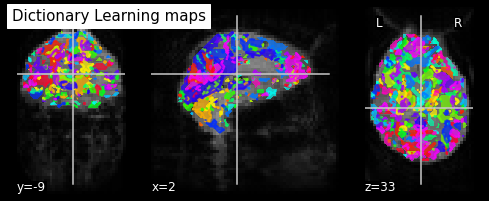

In [3]:
import warnings
warnings.filterwarnings(action='once')
from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=20, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_file)
# Resting state networks/maps in attribute `components_img_`
components_img = dict_learn.components_img_

# Visualization of functional networks
# Show networks using plotting utilities
from nilearn.image import mean_img
from nilearn import plotting
mean_haxby = mean_img(func_file)
plotting.plot_prob_atlas(components_img, 
                         bg_img=mean_haxby, 
                         view_type='filled_contours',
                         title='Dictionary Learning maps')

### Region extraction from network components

This approach has been previously used in the neuroscience literature to study the intrinsic organization of brain anatomy and functions.
The next step is to separate the learned networks into discrete regions.
Nilearn provides an useful class `RegionExtractor` to extract isolated regions from statistical maps.
As the networks generated from dictionary learning are denoted by probablilty rather than discrete values,
we will use `RegionExtractor` to generate a parcellation scheme.

```{admonition} Extract connected regions from a brain atlas image defined by labels (integers). 
:class: tip
See function `nilearn.regions.connected_label_regions` and the tutorial on 
[Yeo 7 networks](https://nilearn.github.io/auto_examples/06_manipulating_images/plot_extract_regions_labels_image.html#sphx-glr-auto-examples-06-manipulating-images-plot-extract-regions-labels-image-py)
```

<decorator-gen-7>:2: DeprecationWarning: scipy.sparse.linalg.cg called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``cg(..., atol=0)``, or to retain the old behavior ``cg(..., atol='legacy')``


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/image/image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(data_2d.copy(),


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/numpy/ma/core.py:2831: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


/home/haoting/.virtualenvs/brain_encoding_decoding/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


(1452, 68)


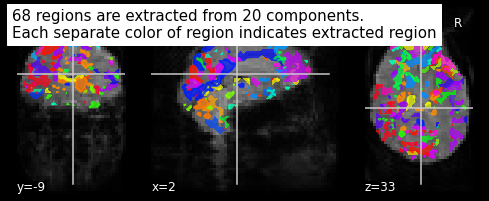

In [4]:
import warnings
warnings.filterwarnings(action='once')
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 20))
plotting.plot_prob_atlas(regions_extracted_img, 
                         bg_img=mean_haxby, 
                         view_type='filled_contours',
                         title=title)

X = extractor.transform(func_file)
print(X.shape)

So we have 1452 time points in the imaging data, and for each time point we have recordings of fMRI activity across 68 brain regions.

## Create brain graph for GCN

A key component of GCN is brain graph.
Brain graph provides a network representation of brain organization by associating nodes to brain regions and defining edges via anatomical or functional connections.
After generating time series, we will firstly use the nilearn function to geneate a correlation based functional connectome.

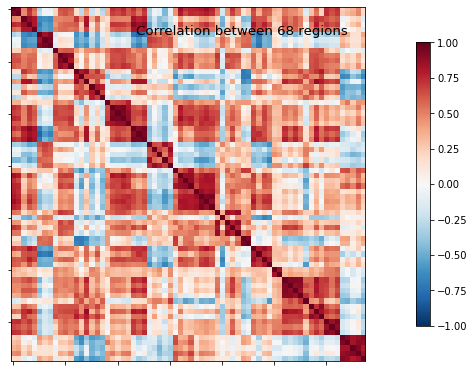

In [5]:
import warnings
warnings.filterwarnings(action='once')

import nilearn.connectome

# Estimating connectomes and save for pytorch to load
corr_measure = nilearn.connectome.ConnectivityMeasure(kind="correlation")
conn = corr_measure.fit_transform([X])[0]

title = 'Correlation between %d regions' % n_regions_extracted

# First plot the matrix
display = plotting.plot_matrix(conn, vmax=1, vmin=-1,
                               colorbar=True, title=title)


The next step is to construct the brain graph for GCN.

__k-Nearest Neighbours(KNN) graph__ for the group average connectome will be built based on the connectivity-matrix.

Each node is only connected to *k* conn = corr_measure.fit_transform([X])[0]
other neighbouring nodes.
For the purpose of demostration, we constrain the graph to from clusters with __8__ neighbouring nodes with the strongest connectivity.

For more details you please check out __*src/graph_construction.py*__ script.

In [6]:
import sys
sys.path.append('../src')
from graph_construction import make_group_graph

# make a graph for the subject
graph = make_group_graph([conn], self_loops=False, k=8, symmetric=True)

## Preparing the dataset for model training

The trials for different object categories are scattered in the experiment. 
Firstly we will concatenated the volumes of the same category together.

In [7]:
# generate data
import pandas as pd
import numpy as np

# cancatenate the same type of trials
concat_bold = {}
for label in categories:
    cur_label_index = y.index[y == label].tolist()
    curr_bold_seg = X[cur_label_index]    
    concat_bold[label] = curr_bold_seg

We split the data by the time window size that we wish to use to caputre the temporal dynamic.
Different lengths for our input data can be selected. 
In this example we will continue with __*window_length = 1*__, which means each input file will have a length equal to just one Repetition Time (TR).
The splitted timeseries are saved as individual files (in the format of `<category>_seg_<serialnumber>.npy`), 
the file names and the associated label are stored in the same directory,
under a file named `label.csv`.

In [8]:
# split the data by time window size and save to file
window_length = 1
dic_labels = {name: i for i, name in enumerate(categories)}

# set output paths
split_path = os.path.join(data_dir, 'haxby_split_win/')
if not os.path.exists(split_path):
    os.makedirs(split_path)
out_file = os.path.join(split_path, '{}_{:04d}.npy')
out_csv = os.path.join(split_path, 'labels.csv')

label_df = pd.DataFrame(columns=['label', 'filename'])
for label, ts_data in concat_bold.items():
    ts_duration = len(ts_data)
    ts_filename = f"{label}_seg"
    valid_label = dic_labels[label]

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))

    ts_data = ts_data[:(ts_duration - rem), :]   

    for j, split_ts in enumerate(np.split(ts_data, n_splits)):
        ts_output_file_name = out_file.format(ts_filename, j)

        split_ts = np.swapaxes(split_ts, 0, 1)
        np.save(ts_output_file_name, split_ts)

        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_name)}
        label_df = label_df.append(curr_label, ignore_index=True)
        
label_df.to_csv(out_csv, index=False)  

Now we use a customised `pytorch` dataset generator class `TimeWindowsDataset` to split the data into training, 
validation, and testing sets for model selection.

```{admonition} Model selection
:class: tip
For further details of model selection, please check out the material from [this tutorial](https://github.com/neurodatascience/main-2021-ml-parts-1-2).
```

The dataset generator defaults isolates 20% of the data as the validation set, and 10% as testing set.
For more details of customising a dataset, please see `src/gcn_windows_dataset.py` and the 
official [`pytorch` documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files).

In [9]:
# split dataset
from gcn_windows_dataset import TimeWindowsDataset

random_seed = 0

train_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="train", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

valid_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="valid", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

test_dataset = TimeWindowsDataset(
    data_dir=split_path, 
    partition="test", 
    random_seed=random_seed, 
    pin_memory=True, 
    normalize=True,
    shuffle=True)

print("train dataset: {}".format(train_dataset))
print("valid dataset: {}".format(valid_dataset))
print("test dataset: {}".format(test_dataset))

train dataset: 1016*(torch.Size([68, 1]), ())
valid dataset: 290*(torch.Size([68, 1]), ())
test dataset: 146*(torch.Size([68, 1]), ())


Once the datasets are created, we can use the pytorch [data loader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to iterate through the data during the model selection process.
The __batch size__ defines the number of samples that will be propagated through the neural network.
We are separating the dataset into 16 time windows per batch.

In [10]:
import torch
from torch.utils.data import DataLoader

batch_size = 16

torch.manual_seed(random_seed)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_features, train_labels = next(iter(train_generator))
print(f"Feature batch shape: {train_features.size()}; mean {torch.mean(train_features)}")
print(f"Labels batch shape: {train_labels.size()}; mean {torch.mean(torch.Tensor.float(train_labels))}")

Feature batch shape: torch.Size([16, 68, 1]); mean -8.76538930327797e-09
Labels batch shape: torch.Size([16]); mean 3.8125


## Generating a GCN model 

We have created a GCN of the following property:
- __3__ graph convolutional layers
- __32 graph filters__  at each layer
- followed by a __global average pooling__ layer
- __2 fully connected__ layers

In [11]:
from gcn_model import GCN

gcn = GCN(graph.edge_index, 
          graph.edge_attr, 
          n_roi=X.shape[1],
          batch_size=batch_size,
          n_timepoints=window_length, 
          n_classes=len(categories))
gcn

GCN(
  (conv1): ChebConv(1, 32, K=2, normalization=sym)
  (conv2): ChebConv(32, 32, K=2, normalization=sym)
  (conv3): ChebConv(32, 16, K=2, normalization=sym)
  (fc1): Linear(in_features=1088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=9, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train and evaluating the model

We will use a procedure called backpropagation to train the model.
When we training the model with the first batch of data, the accuarcy and loss will be pretty poor.
Backpropagation is an algorithm to update the model based on the rate of loss. 
Iterating through each batch, the model will be updated and reduce the loss.

Function `training_loop` performs backpropagation through pytorch. 
One can use their own choice of optimizer for backpropagation and estimator for loss.

After one round of training, we use the validation dataset to calculate the average accuracy and loss with function `valid_test_loop`. 
These metrics will serve as the reference for model performance of this round of training.

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
        if (batch % 10 == 0) or (current == size):
            print(f"#{batch:>5};\ttrain_loss: {loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

        
def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct

This whole procedure described above is called an __epoch__.
We will repeat the process for 60 epochs.
Here the choice of loss function is `CrossEntropyLoss` and the optimizer to update the model is `Adam`.

In [13]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 60
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

Epoch 1/60
-------------------------------
#    0;	train_loss: 2.185;	train_accuracy: 18.8%		[    0/ 1016]


#   10;	train_loss: 2.116;	train_accuracy: 31.2%		[  160/ 1016]
#   20;	train_loss: 1.914;	train_accuracy: 56.2%		[  320/ 1016]


#   30;	train_loss: 2.053;	train_accuracy: 31.2%		[  480/ 1016]
#   40;	train_loss: 1.958;	train_accuracy: 37.5%		[  640/ 1016]


#   50;	train_loss: 1.817;	train_accuracy: 43.8%		[  800/ 1016]
#   60;	train_loss: 1.840;	train_accuracy: 43.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.120069;	 avg_accuracy: 43.4%
Epoch 2/60
-------------------------------
#    0;	train_loss: 1.723;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 1.933;	train_accuracy: 37.5%		[  160/ 1016]


#   20;	train_loss: 1.735;	train_accuracy: 50.0%		[  320/ 1016]
#   30;	train_loss: 1.925;	train_accuracy: 37.5%		[  480/ 1016]


#   40;	train_loss: 1.879;	train_accuracy: 37.5%		[  640/ 1016]
#   50;	train_loss: 1.353;	train_accuracy: 68.8%		[  800/ 1016]


#   60;	train_loss: 1.800;	train_accuracy: 43.8%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.116934;	 avg_accuracy: 43.4%
Epoch 3/60
-------------------------------


#    0;	train_loss: 1.630;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 1.885;	train_accuracy: 37.5%		[  160/ 1016]


#   20;	train_loss: 1.675;	train_accuracy: 43.8%		[  320/ 1016]
#   30;	train_loss: 2.008;	train_accuracy: 31.2%		[  480/ 1016]


#   40;	train_loss: 1.749;	train_accuracy: 37.5%		[  640/ 1016]


#   50;	train_loss: 1.586;	train_accuracy: 50.0%		[  800/ 1016]
#   60;	train_loss: 1.944;	train_accuracy: 31.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.108797;	 avg_accuracy: 43.4%
Epoch 4/60
-------------------------------
#    0;	train_loss: 1.997;	train_accuracy: 37.5%		[    0/ 1016]
#   10;	train_loss: 2.130;	train_accuracy: 25.0%		[  160/ 1016]


#   20;	train_loss: 1.683;	train_accuracy: 43.8%		[  320/ 1016]
#   30;	train_loss: 1.534;	train_accuracy: 50.0%		[  480/ 1016]


#   40;	train_loss: 1.784;	train_accuracy: 37.5%		[  640/ 1016]
#   50;	train_loss: 1.787;	train_accuracy: 37.5%		[  800/ 1016]


#   60;	train_loss: 1.424;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.109635;	 avg_accuracy: 44.1%
Epoch 5/60
-------------------------------
#    0;	train_loss: 1.277;	train_accuracy: 56.2%		[    0/ 1016]


#   10;	train_loss: 1.509;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 1.458;	train_accuracy: 50.0%		[  320/ 1016]


#   30;	train_loss: 1.791;	train_accuracy: 43.8%		[  480/ 1016]
#   40;	train_loss: 1.511;	train_accuracy: 43.8%		[  640/ 1016]


#   50;	train_loss: 1.531;	train_accuracy: 50.0%		[  800/ 1016]
#   60;	train_loss: 1.602;	train_accuracy: 31.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.104901;	 avg_accuracy: 46.6%
Epoch 6/60
-------------------------------
#    0;	train_loss: 1.447;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 1.384;	train_accuracy: 56.2%		[  160/ 1016]


#   20;	train_loss: 2.029;	train_accuracy: 25.0%		[  320/ 1016]
#   30;	train_loss: 1.767;	train_accuracy: 37.5%		[  480/ 1016]


#   40;	train_loss: 1.581;	train_accuracy: 37.5%		[  640/ 1016]
#   50;	train_loss: 1.421;	train_accuracy: 56.2%		[  800/ 1016]


#   60;	train_loss: 1.479;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.106867;	 avg_accuracy: 46.6%
Epoch 7/60
-------------------------------
#    0;	train_loss: 1.393;	train_accuracy: 68.8%		[    0/ 1016]


#   10;	train_loss: 1.732;	train_accuracy: 31.2%		[  160/ 1016]
#   20;	train_loss: 1.625;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.268;	train_accuracy: 68.8%		[  480/ 1016]
#   40;	train_loss: 1.666;	train_accuracy: 31.2%		[  640/ 1016]


#   50;	train_loss: 1.752;	train_accuracy: 37.5%		[  800/ 1016]
#   60;	train_loss: 1.298;	train_accuracy: 50.0%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.098790;	 avg_accuracy: 49.7%
Epoch 8/60
-------------------------------
#    0;	train_loss: 1.488;	train_accuracy: 56.2%		[    0/ 1016]
#   10;	train_loss: 1.157;	train_accuracy: 68.8%		[  160/ 1016]


#   20;	train_loss: 1.427;	train_accuracy: 68.8%		[  320/ 1016]
#   30;	train_loss: 1.537;	train_accuracy: 43.8%		[  480/ 1016]


#   40;	train_loss: 1.286;	train_accuracy: 56.2%		[  640/ 1016]
#   50;	train_loss: 1.286;	train_accuracy: 56.2%		[  800/ 1016]


#   60;	train_loss: 1.436;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.100907;	 avg_accuracy: 50.0%
Epoch 9/60
-------------------------------
#    0;	train_loss: 1.784;	train_accuracy: 37.5%		[    0/ 1016]


#   10;	train_loss: 1.215;	train_accuracy: 68.8%		[  160/ 1016]
#   20;	train_loss: 1.873;	train_accuracy: 37.5%		[  320/ 1016]


#   30;	train_loss: 1.428;	train_accuracy: 50.0%		[  480/ 1016]
#   40;	train_loss: 1.460;	train_accuracy: 50.0%		[  640/ 1016]


#   50;	train_loss: 1.521;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 1.715;	train_accuracy: 43.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.100672;	 avg_accuracy: 48.6%
Epoch 10/60
-------------------------------
#    0;	train_loss: 2.264;	train_accuracy: 31.2%		[    0/ 1016]
#   10;	train_loss: 1.981;	train_accuracy: 37.5%		[  160/ 1016]


#   20;	train_loss: 2.123;	train_accuracy: 31.2%		[  320/ 1016]
#   30;	train_loss: 1.287;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.826;	train_accuracy: 43.8%		[  640/ 1016]
#   50;	train_loss: 1.732;	train_accuracy: 31.2%		[  800/ 1016]


#   60;	train_loss: 1.434;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.102185;	 avg_accuracy: 47.6%
Epoch 11/60
-------------------------------
#    0;	train_loss: 1.341;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 1.254;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 1.391;	train_accuracy: 50.0%		[  320/ 1016]


#   30;	train_loss: 1.538;	train_accuracy: 37.5%		[  480/ 1016]
#   40;	train_loss: 1.381;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 1.948;	train_accuracy: 31.2%		[  800/ 1016]
#   60;	train_loss: 1.583;	train_accuracy: 37.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.102398;	 avg_accuracy: 49.7%
Epoch 12/60
-------------------------------
#    0;	train_loss: 1.220;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 1.778;	train_accuracy: 31.2%		[  160/ 1016]


#   20;	train_loss: 1.906;	train_accuracy: 31.2%		[  320/ 1016]
#   30;	train_loss: 1.422;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.784;	train_accuracy: 43.8%		[  640/ 1016]
#   50;	train_loss: 1.696;	train_accuracy: 37.5%		[  800/ 1016]


#   60;	train_loss: 1.311;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.095115;	 avg_accuracy: 51.7%
Epoch 13/60
-------------------------------
#    0;	train_loss: 1.031;	train_accuracy: 68.8%		[    0/ 1016]


#   10;	train_loss: 1.573;	train_accuracy: 37.5%		[  160/ 1016]
#   20;	train_loss: 1.863;	train_accuracy: 37.5%		[  320/ 1016]


#   30;	train_loss: 1.276;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 1.275;	train_accuracy: 56.2%		[  640/ 1016]


#   50;	train_loss: 1.605;	train_accuracy: 25.0%		[  800/ 1016]
#   60;	train_loss: 1.589;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.094385;	 avg_accuracy: 53.1%
Epoch 14/60
-------------------------------
#    0;	train_loss: 1.344;	train_accuracy: 43.8%		[    0/ 1016]
#   10;	train_loss: 1.164;	train_accuracy: 50.0%		[  160/ 1016]


#   20;	train_loss: 1.336;	train_accuracy: 50.0%		[  320/ 1016]
#   30;	train_loss: 1.747;	train_accuracy: 37.5%		[  480/ 1016]


#   40;	train_loss: 1.097;	train_accuracy: 62.5%		[  640/ 1016]
#   50;	train_loss: 1.210;	train_accuracy: 62.5%		[  800/ 1016]


#   60;	train_loss: 2.111;	train_accuracy: 31.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.096174;	 avg_accuracy: 51.4%
Epoch 15/60
-------------------------------
#    0;	train_loss: 1.144;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 1.691;	train_accuracy: 37.5%		[  160/ 1016]
#   20;	train_loss: 1.001;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.300;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 1.687;	train_accuracy: 31.2%		[  640/ 1016]


#   50;	train_loss: 1.135;	train_accuracy: 68.8%		[  800/ 1016]
#   60;	train_loss: 1.571;	train_accuracy: 50.0%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.096130;	 avg_accuracy: 51.7%
Epoch 16/60
-------------------------------
#    0;	train_loss: 1.232;	train_accuracy: 56.2%		[    0/ 1016]
#   10;	train_loss: 1.393;	train_accuracy: 56.2%		[  160/ 1016]


#   20;	train_loss: 1.469;	train_accuracy: 43.8%		[  320/ 1016]
#   30;	train_loss: 2.005;	train_accuracy: 25.0%		[  480/ 1016]


#   40;	train_loss: 1.255;	train_accuracy: 62.5%		[  640/ 1016]
#   50;	train_loss: 1.361;	train_accuracy: 62.5%		[  800/ 1016]


#   60;	train_loss: 1.534;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.095889;	 avg_accuracy: 52.4%
Epoch 17/60
-------------------------------
#    0;	train_loss: 1.407;	train_accuracy: 43.8%		[    0/ 1016]
#   10;	train_loss: 1.391;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 1.746;	train_accuracy: 50.0%		[  320/ 1016]
#   30;	train_loss: 1.509;	train_accuracy: 56.2%		[  480/ 1016]


#   40;	train_loss: 1.071;	train_accuracy: 68.8%		[  640/ 1016]
#   50;	train_loss: 1.276;	train_accuracy: 56.2%		[  800/ 1016]


#   60;	train_loss: 1.820;	train_accuracy: 37.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.090174;	 avg_accuracy: 52.4%
Epoch 18/60
-------------------------------
#    0;	train_loss: 1.054;	train_accuracy: 68.8%		[    0/ 1016]
#   10;	train_loss: 1.586;	train_accuracy: 56.2%		[  160/ 1016]


#   20;	train_loss: 1.297;	train_accuracy: 43.8%		[  320/ 1016]
#   30;	train_loss: 1.593;	train_accuracy: 50.0%		[  480/ 1016]


#   40;	train_loss: 0.973;	train_accuracy: 81.2%		[  640/ 1016]
#   50;	train_loss: 1.187;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 1.393;	train_accuracy: 43.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.095324;	 avg_accuracy: 51.7%
Epoch 19/60
-------------------------------
#    0;	train_loss: 1.569;	train_accuracy: 43.8%		[    0/ 1016]
#   10;	train_loss: 1.427;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 1.157;	train_accuracy: 56.2%		[  320/ 1016]
#   30;	train_loss: 1.182;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.947;	train_accuracy: 37.5%		[  640/ 1016]
#   50;	train_loss: 1.095;	train_accuracy: 68.8%		[  800/ 1016]


#   60;	train_loss: 1.642;	train_accuracy: 37.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.095229;	 avg_accuracy: 51.7%
Epoch 20/60
-------------------------------
#    0;	train_loss: 1.671;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 1.765;	train_accuracy: 50.0%		[  160/ 1016]


#   20;	train_loss: 1.353;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 1.095;	train_accuracy: 68.8%		[  480/ 1016]


#   40;	train_loss: 1.494;	train_accuracy: 50.0%		[  640/ 1016]
#   50;	train_loss: 1.555;	train_accuracy: 50.0%		[  800/ 1016]


#   60;	train_loss: 1.089;	train_accuracy: 62.5%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.092922;	 avg_accuracy: 51.7%
Epoch 21/60
-------------------------------
#    0;	train_loss: 1.661;	train_accuracy: 50.0%		[    0/ 1016]


#   10;	train_loss: 1.597;	train_accuracy: 56.2%		[  160/ 1016]
#   20;	train_loss: 1.541;	train_accuracy: 56.2%		[  320/ 1016]


#   30;	train_loss: 1.165;	train_accuracy: 62.5%		[  480/ 1016]
#   40;	train_loss: 1.174;	train_accuracy: 50.0%		[  640/ 1016]


#   50;	train_loss: 1.331;	train_accuracy: 56.2%		[  800/ 1016]
#   60;	train_loss: 1.819;	train_accuracy: 43.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.086993;	 avg_accuracy: 54.8%
Epoch 22/60
-------------------------------
#    0;	train_loss: 1.080;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 1.090;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 1.319;	train_accuracy: 56.2%		[  320/ 1016]
#   30;	train_loss: 1.112;	train_accuracy: 50.0%		[  480/ 1016]


#   40;	train_loss: 1.394;	train_accuracy: 50.0%		[  640/ 1016]
#   50;	train_loss: 1.063;	train_accuracy: 56.2%		[  800/ 1016]


#   60;	train_loss: 1.601;	train_accuracy: 37.5%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.087692;	 avg_accuracy: 54.1%
Epoch 23/60
-------------------------------
#    0;	train_loss: 1.409;	train_accuracy: 31.2%		[    0/ 1016]


#   10;	train_loss: 1.276;	train_accuracy: 50.0%		[  160/ 1016]
#   20;	train_loss: 0.979;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.012;	train_accuracy: 62.5%		[  480/ 1016]
#   40;	train_loss: 1.761;	train_accuracy: 50.0%		[  640/ 1016]


#   50;	train_loss: 1.407;	train_accuracy: 50.0%		[  800/ 1016]
#   60;	train_loss: 1.416;	train_accuracy: 50.0%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.092176;	 avg_accuracy: 52.4%
Epoch 24/60
-------------------------------
#    0;	train_loss: 1.289;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 1.135;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 0.753;	train_accuracy: 81.2%		[  320/ 1016]
#   30;	train_loss: 1.093;	train_accuracy: 75.0%		[  480/ 1016]


#   40;	train_loss: 1.504;	train_accuracy: 43.8%		[  640/ 1016]
#   50;	train_loss: 1.503;	train_accuracy: 37.5%		[  800/ 1016]


#   60;	train_loss: 1.075;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.087937;	 avg_accuracy: 53.1%
Epoch 25/60
-------------------------------
#    0;	train_loss: 0.823;	train_accuracy: 68.8%		[    0/ 1016]


#   10;	train_loss: 0.955;	train_accuracy: 56.2%		[  160/ 1016]
#   20;	train_loss: 1.005;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.674;	train_accuracy: 25.0%		[  480/ 1016]
#   40;	train_loss: 1.831;	train_accuracy: 43.8%		[  640/ 1016]


#   50;	train_loss: 1.092;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 1.212;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.084159;	 avg_accuracy: 54.5%
Epoch 26/60
-------------------------------
#    0;	train_loss: 1.018;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 1.768;	train_accuracy: 31.2%		[  160/ 1016]


#   20;	train_loss: 1.293;	train_accuracy: 50.0%		[  320/ 1016]
#   30;	train_loss: 1.146;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.551;	train_accuracy: 43.8%		[  640/ 1016]
#   50;	train_loss: 1.598;	train_accuracy: 50.0%		[  800/ 1016]


#   60;	train_loss: 1.035;	train_accuracy: 62.5%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.091921;	 avg_accuracy: 52.1%
Epoch 27/60
-------------------------------
#    0;	train_loss: 1.437;	train_accuracy: 50.0%		[    0/ 1016]


#   10;	train_loss: 1.202;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 0.943;	train_accuracy: 75.0%		[  320/ 1016]


#   30;	train_loss: 0.821;	train_accuracy: 68.8%		[  480/ 1016]
#   40;	train_loss: 1.001;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 1.310;	train_accuracy: 56.2%		[  800/ 1016]
#   60;	train_loss: 1.166;	train_accuracy: 62.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.089945;	 avg_accuracy: 55.9%
Epoch 28/60
-------------------------------
#    0;	train_loss: 1.121;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 1.800;	train_accuracy: 43.8%		[  160/ 1016]


#   20;	train_loss: 1.199;	train_accuracy: 56.2%		[  320/ 1016]
#   30;	train_loss: 1.259;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.606;	train_accuracy: 43.8%		[  640/ 1016]
#   50;	train_loss: 1.057;	train_accuracy: 62.5%		[  800/ 1016]


#   60;	train_loss: 1.223;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.085927;	 avg_accuracy: 57.6%
Epoch 29/60
-------------------------------
#    0;	train_loss: 0.838;	train_accuracy: 75.0%		[    0/ 1016]


#   10;	train_loss: 0.967;	train_accuracy: 68.8%		[  160/ 1016]
#   20;	train_loss: 1.187;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.042;	train_accuracy: 62.5%		[  480/ 1016]
#   40;	train_loss: 1.340;	train_accuracy: 50.0%		[  640/ 1016]


#   50;	train_loss: 1.098;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 0.796;	train_accuracy: 93.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.082808;	 avg_accuracy: 57.9%
Epoch 30/60
-------------------------------
#    0;	train_loss: 0.802;	train_accuracy: 87.5%		[    0/ 1016]
#   10;	train_loss: 1.038;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 0.573;	train_accuracy: 81.2%		[  320/ 1016]
#   30;	train_loss: 1.496;	train_accuracy: 43.8%		[  480/ 1016]


#   40;	train_loss: 1.234;	train_accuracy: 62.5%		[  640/ 1016]
#   50;	train_loss: 1.725;	train_accuracy: 50.0%		[  800/ 1016]


#   60;	train_loss: 1.066;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.085872;	 avg_accuracy: 57.9%
Epoch 31/60
-------------------------------
#    0;	train_loss: 0.959;	train_accuracy: 75.0%		[    0/ 1016]


#   10;	train_loss: 1.514;	train_accuracy: 50.0%		[  160/ 1016]
#   20;	train_loss: 1.021;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.542;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 1.019;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 1.708;	train_accuracy: 31.2%		[  800/ 1016]
#   60;	train_loss: 1.116;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.089618;	 avg_accuracy: 58.6%
Epoch 32/60
-------------------------------
#    0;	train_loss: 1.717;	train_accuracy: 31.2%		[    0/ 1016]
#   10;	train_loss: 1.774;	train_accuracy: 37.5%		[  160/ 1016]


#   20;	train_loss: 1.402;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 0.753;	train_accuracy: 68.8%		[  480/ 1016]


#   40;	train_loss: 1.507;	train_accuracy: 37.5%		[  640/ 1016]
#   50;	train_loss: 1.150;	train_accuracy: 68.8%		[  800/ 1016]


#   60;	train_loss: 1.348;	train_accuracy: 43.8%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.080904;	 avg_accuracy: 62.1%
Epoch 33/60
-------------------------------
#    0;	train_loss: 1.350;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 1.418;	train_accuracy: 50.0%		[  160/ 1016]
#   20;	train_loss: 0.985;	train_accuracy: 81.2%		[  320/ 1016]


#   30;	train_loss: 0.908;	train_accuracy: 75.0%		[  480/ 1016]
#   40;	train_loss: 1.134;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 1.029;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 1.391;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.082991;	 avg_accuracy: 60.7%
Epoch 34/60
-------------------------------
#    0;	train_loss: 1.373;	train_accuracy: 43.8%		[    0/ 1016]
#   10;	train_loss: 0.596;	train_accuracy: 87.5%		[  160/ 1016]


#   20;	train_loss: 1.498;	train_accuracy: 43.8%		[  320/ 1016]
#   30;	train_loss: 0.836;	train_accuracy: 81.2%		[  480/ 1016]


#   40;	train_loss: 0.736;	train_accuracy: 81.2%		[  640/ 1016]
#   50;	train_loss: 0.778;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 0.563;	train_accuracy: 81.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.085427;	 avg_accuracy: 57.6%
Epoch 35/60
-------------------------------
#    0;	train_loss: 1.450;	train_accuracy: 50.0%		[    0/ 1016]


#   10;	train_loss: 1.168;	train_accuracy: 50.0%		[  160/ 1016]
#   20;	train_loss: 1.012;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 0.829;	train_accuracy: 87.5%		[  480/ 1016]
#   40;	train_loss: 0.717;	train_accuracy: 75.0%		[  640/ 1016]


#   50;	train_loss: 1.115;	train_accuracy: 56.2%		[  800/ 1016]
#   60;	train_loss: 1.286;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.078114;	 avg_accuracy: 60.7%
Epoch 36/60
-------------------------------
#    0;	train_loss: 1.150;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 1.278;	train_accuracy: 50.0%		[  160/ 1016]


#   20;	train_loss: 0.892;	train_accuracy: 75.0%		[  320/ 1016]
#   30;	train_loss: 1.101;	train_accuracy: 68.8%		[  480/ 1016]


#   40;	train_loss: 0.836;	train_accuracy: 68.8%		[  640/ 1016]
#   50;	train_loss: 1.173;	train_accuracy: 50.0%		[  800/ 1016]


#   60;	train_loss: 1.364;	train_accuracy: 50.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.079527;	 avg_accuracy: 59.7%
Epoch 37/60
-------------------------------
#    0;	train_loss: 1.402;	train_accuracy: 50.0%		[    0/ 1016]


#   10;	train_loss: 0.626;	train_accuracy: 93.8%		[  160/ 1016]
#   20;	train_loss: 1.124;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.206;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 1.229;	train_accuracy: 43.8%		[  640/ 1016]


#   50;	train_loss: 0.882;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 0.889;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.086309;	 avg_accuracy: 59.0%
Epoch 38/60
-------------------------------
#    0;	train_loss: 0.939;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 0.803;	train_accuracy: 75.0%		[  160/ 1016]


#   20;	train_loss: 1.343;	train_accuracy: 56.2%		[  320/ 1016]
#   30;	train_loss: 1.099;	train_accuracy: 56.2%		[  480/ 1016]


#   40;	train_loss: 1.044;	train_accuracy: 56.2%		[  640/ 1016]
#   50;	train_loss: 1.145;	train_accuracy: 62.5%		[  800/ 1016]


#   60;	train_loss: 0.802;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.081069;	 avg_accuracy: 61.0%
Epoch 39/60
-------------------------------
#    0;	train_loss: 0.980;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 0.755;	train_accuracy: 81.2%		[  160/ 1016]
#   20;	train_loss: 0.884;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.531;	train_accuracy: 50.0%		[  480/ 1016]
#   40;	train_loss: 1.107;	train_accuracy: 50.0%		[  640/ 1016]


#   50;	train_loss: 1.734;	train_accuracy: 50.0%		[  800/ 1016]
#   60;	train_loss: 1.056;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.084764;	 avg_accuracy: 58.6%
Epoch 40/60
-------------------------------
#    0;	train_loss: 0.804;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 0.590;	train_accuracy: 87.5%		[  160/ 1016]


#   20;	train_loss: 0.598;	train_accuracy: 81.2%		[  320/ 1016]
#   30;	train_loss: 0.945;	train_accuracy: 75.0%		[  480/ 1016]


#   40;	train_loss: 1.169;	train_accuracy: 62.5%		[  640/ 1016]
#   50;	train_loss: 1.018;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 1.440;	train_accuracy: 50.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.092644;	 avg_accuracy: 54.8%
Epoch 41/60
-------------------------------
#    0;	train_loss: 0.762;	train_accuracy: 81.2%		[    0/ 1016]


#   10;	train_loss: 1.075;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 1.022;	train_accuracy: 68.8%		[  320/ 1016]


#   30;	train_loss: 1.459;	train_accuracy: 50.0%		[  480/ 1016]
#   40;	train_loss: 0.700;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 0.808;	train_accuracy: 68.8%		[  800/ 1016]
#   60;	train_loss: 1.163;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.077349;	 avg_accuracy: 59.7%
Epoch 42/60
-------------------------------
#    0;	train_loss: 1.341;	train_accuracy: 50.0%		[    0/ 1016]
#   10;	train_loss: 0.526;	train_accuracy: 87.5%		[  160/ 1016]


#   20;	train_loss: 1.236;	train_accuracy: 50.0%		[  320/ 1016]
#   30;	train_loss: 1.351;	train_accuracy: 56.2%		[  480/ 1016]


#   40;	train_loss: 1.238;	train_accuracy: 68.8%		[  640/ 1016]
#   50;	train_loss: 0.846;	train_accuracy: 62.5%		[  800/ 1016]


#   60;	train_loss: 1.459;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.084832;	 avg_accuracy: 60.0%
Epoch 43/60
-------------------------------
#    0;	train_loss: 0.769;	train_accuracy: 75.0%		[    0/ 1016]


#   10;	train_loss: 0.788;	train_accuracy: 68.8%		[  160/ 1016]
#   20;	train_loss: 1.044;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.055;	train_accuracy: 62.5%		[  480/ 1016]
#   40;	train_loss: 1.131;	train_accuracy: 56.2%		[  640/ 1016]


#   50;	train_loss: 1.429;	train_accuracy: 43.8%		[  800/ 1016]
#   60;	train_loss: 1.286;	train_accuracy: 50.0%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.073437;	 avg_accuracy: 60.3%
Epoch 44/60
-------------------------------
#    0;	train_loss: 0.683;	train_accuracy: 75.0%		[    0/ 1016]
#   10;	train_loss: 0.873;	train_accuracy: 75.0%		[  160/ 1016]


#   20;	train_loss: 0.657;	train_accuracy: 81.2%		[  320/ 1016]
#   30;	train_loss: 1.131;	train_accuracy: 56.2%		[  480/ 1016]


#   40;	train_loss: 1.143;	train_accuracy: 62.5%		[  640/ 1016]
#   50;	train_loss: 0.902;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 0.754;	train_accuracy: 81.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.078958;	 avg_accuracy: 62.8%
Epoch 45/60
-------------------------------
#    0;	train_loss: 1.162;	train_accuracy: 50.0%		[    0/ 1016]


#   10;	train_loss: 0.448;	train_accuracy: 93.8%		[  160/ 1016]
#   20;	train_loss: 0.948;	train_accuracy: 75.0%		[  320/ 1016]


#   30;	train_loss: 0.373;	train_accuracy: 87.5%		[  480/ 1016]
#   40;	train_loss: 1.077;	train_accuracy: 56.2%		[  640/ 1016]


#   50;	train_loss: 0.806;	train_accuracy: 75.0%		[  800/ 1016]
#   60;	train_loss: 0.908;	train_accuracy: 62.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.075822;	 avg_accuracy: 62.1%
Epoch 46/60
-------------------------------
#    0;	train_loss: 0.936;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 0.967;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 1.036;	train_accuracy: 68.8%		[  320/ 1016]
#   30;	train_loss: 0.699;	train_accuracy: 81.2%		[  480/ 1016]


#   40;	train_loss: 0.668;	train_accuracy: 68.8%		[  640/ 1016]
#   50;	train_loss: 0.993;	train_accuracy: 68.8%		[  800/ 1016]


#   60;	train_loss: 0.789;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.083496;	 avg_accuracy: 61.0%
Epoch 47/60
-------------------------------
#    0;	train_loss: 1.161;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 0.831;	train_accuracy: 81.2%		[  160/ 1016]
#   20;	train_loss: 1.315;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 0.983;	train_accuracy: 62.5%		[  480/ 1016]
#   40;	train_loss: 0.911;	train_accuracy: 68.8%		[  640/ 1016]


#   50;	train_loss: 0.780;	train_accuracy: 81.2%		[  800/ 1016]
#   60;	train_loss: 0.791;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.074051;	 avg_accuracy: 63.1%
Epoch 48/60
-------------------------------
#    0;	train_loss: 0.965;	train_accuracy: 68.8%		[    0/ 1016]
#   10;	train_loss: 0.540;	train_accuracy: 87.5%		[  160/ 1016]


#   20;	train_loss: 1.178;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 0.685;	train_accuracy: 75.0%		[  480/ 1016]


#   40;	train_loss: 0.949;	train_accuracy: 75.0%		[  640/ 1016]
#   50;	train_loss: 0.766;	train_accuracy: 68.8%		[  800/ 1016]


#   60;	train_loss: 1.293;	train_accuracy: 56.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.084825;	 avg_accuracy: 61.0%
Epoch 49/60
-------------------------------
#    0;	train_loss: 0.838;	train_accuracy: 75.0%		[    0/ 1016]


#   10;	train_loss: 1.591;	train_accuracy: 43.8%		[  160/ 1016]
#   20;	train_loss: 0.967;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.100;	train_accuracy: 68.8%		[  480/ 1016]
#   40;	train_loss: 0.721;	train_accuracy: 87.5%		[  640/ 1016]


#   50;	train_loss: 1.039;	train_accuracy: 68.8%		[  800/ 1016]
#   60;	train_loss: 0.713;	train_accuracy: 75.0%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.078879;	 avg_accuracy: 59.0%
Epoch 50/60
-------------------------------
#    0;	train_loss: 0.663;	train_accuracy: 87.5%		[    0/ 1016]
#   10;	train_loss: 0.778;	train_accuracy: 75.0%		[  160/ 1016]


#   20;	train_loss: 0.836;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 0.744;	train_accuracy: 68.8%		[  480/ 1016]


#   40;	train_loss: 1.249;	train_accuracy: 56.2%		[  640/ 1016]
#   50;	train_loss: 0.494;	train_accuracy: 81.2%		[  800/ 1016]


#   60;	train_loss: 0.760;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.079857;	 avg_accuracy: 59.0%
Epoch 51/60
-------------------------------
#    0;	train_loss: 0.275;	train_accuracy:100.0%		[    0/ 1016]


#   10;	train_loss: 1.359;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 0.234;	train_accuracy: 93.8%		[  320/ 1016]


#   30;	train_loss: 1.388;	train_accuracy: 50.0%		[  480/ 1016]
#   40;	train_loss: 1.091;	train_accuracy: 62.5%		[  640/ 1016]


#   50;	train_loss: 1.048;	train_accuracy: 56.2%		[  800/ 1016]
#   60;	train_loss: 0.570;	train_accuracy: 87.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.077617;	 avg_accuracy: 61.7%
Epoch 52/60
-------------------------------
#    0;	train_loss: 0.717;	train_accuracy: 75.0%		[    0/ 1016]
#   10;	train_loss: 0.775;	train_accuracy: 68.8%		[  160/ 1016]


#   20;	train_loss: 0.851;	train_accuracy: 68.8%		[  320/ 1016]
#   30;	train_loss: 1.102;	train_accuracy: 68.8%		[  480/ 1016]


#   40;	train_loss: 0.640;	train_accuracy: 81.2%		[  640/ 1016]
#   50;	train_loss: 0.790;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 0.471;	train_accuracy: 87.5%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.072935;	 avg_accuracy: 63.1%
Epoch 53/60
-------------------------------
#    0;	train_loss: 0.670;	train_accuracy: 81.2%		[    0/ 1016]


#   10;	train_loss: 0.800;	train_accuracy: 62.5%		[  160/ 1016]
#   20;	train_loss: 1.190;	train_accuracy: 43.8%		[  320/ 1016]


#   30;	train_loss: 1.178;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 0.711;	train_accuracy: 75.0%		[  640/ 1016]


#   50;	train_loss: 0.769;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 0.847;	train_accuracy: 68.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.079889;	 avg_accuracy: 61.7%
Epoch 54/60
-------------------------------
#    0;	train_loss: 0.881;	train_accuracy: 56.2%		[    0/ 1016]
#   10;	train_loss: 0.377;	train_accuracy: 93.8%		[  160/ 1016]


#   20;	train_loss: 0.845;	train_accuracy: 75.0%		[  320/ 1016]
#   30;	train_loss: 0.604;	train_accuracy: 81.2%		[  480/ 1016]


#   40;	train_loss: 0.836;	train_accuracy: 75.0%		[  640/ 1016]
#   50;	train_loss: 0.501;	train_accuracy: 81.2%		[  800/ 1016]


#   60;	train_loss: 0.839;	train_accuracy: 62.5%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.079748;	 avg_accuracy: 62.1%
Epoch 55/60
-------------------------------
#    0;	train_loss: 1.388;	train_accuracy: 62.5%		[    0/ 1016]


#   10;	train_loss: 0.332;	train_accuracy: 81.2%		[  160/ 1016]
#   20;	train_loss: 0.513;	train_accuracy: 87.5%		[  320/ 1016]


#   30;	train_loss: 0.694;	train_accuracy: 81.2%		[  480/ 1016]
#   40;	train_loss: 0.890;	train_accuracy: 56.2%		[  640/ 1016]


#   50;	train_loss: 0.859;	train_accuracy: 68.8%		[  800/ 1016]
#   60;	train_loss: 1.365;	train_accuracy: 56.2%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.074236;	 avg_accuracy: 61.7%
Epoch 56/60
-------------------------------
#    0;	train_loss: 0.873;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 0.887;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 1.121;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 0.918;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 0.606;	train_accuracy: 81.2%		[  640/ 1016]
#   50;	train_loss: 0.651;	train_accuracy: 75.0%		[  800/ 1016]


#   60;	train_loss: 0.456;	train_accuracy: 81.2%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.075418;	 avg_accuracy: 61.4%
Epoch 57/60
-------------------------------
#    0;	train_loss: 1.082;	train_accuracy: 56.2%		[    0/ 1016]


#   10;	train_loss: 0.632;	train_accuracy: 75.0%		[  160/ 1016]
#   20;	train_loss: 0.579;	train_accuracy: 81.2%		[  320/ 1016]


#   30;	train_loss: 1.294;	train_accuracy: 68.8%		[  480/ 1016]
#   40;	train_loss: 0.608;	train_accuracy: 81.2%		[  640/ 1016]


#   50;	train_loss: 0.924;	train_accuracy: 62.5%		[  800/ 1016]
#   60;	train_loss: 1.359;	train_accuracy: 43.8%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.078811;	 avg_accuracy: 59.7%
Epoch 58/60
-------------------------------
#    0;	train_loss: 1.054;	train_accuracy: 62.5%		[    0/ 1016]
#   10;	train_loss: 0.910;	train_accuracy: 62.5%		[  160/ 1016]


#   20;	train_loss: 0.693;	train_accuracy: 81.2%		[  320/ 1016]
#   30;	train_loss: 0.585;	train_accuracy: 81.2%		[  480/ 1016]


#   40;	train_loss: 0.431;	train_accuracy: 87.5%		[  640/ 1016]
#   50;	train_loss: 0.830;	train_accuracy: 87.5%		[  800/ 1016]


#   60;	train_loss: 0.730;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.080051;	 avg_accuracy: 64.8%
Epoch 59/60
-------------------------------
#    0;	train_loss: 0.855;	train_accuracy: 56.2%		[    0/ 1016]


#   10;	train_loss: 0.819;	train_accuracy: 81.2%		[  160/ 1016]
#   20;	train_loss: 0.895;	train_accuracy: 62.5%		[  320/ 1016]


#   30;	train_loss: 1.087;	train_accuracy: 56.2%		[  480/ 1016]
#   40;	train_loss: 0.666;	train_accuracy: 81.2%		[  640/ 1016]


#   50;	train_loss: 0.430;	train_accuracy: 93.8%		[  800/ 1016]
#   60;	train_loss: 0.833;	train_accuracy: 62.5%		[  960/ 1016]


Valid metrics:
	 avg_loss: 0.068422;	 avg_accuracy: 65.5%
Epoch 60/60
-------------------------------
#    0;	train_loss: 0.528;	train_accuracy: 81.2%		[    0/ 1016]
#   10;	train_loss: 0.644;	train_accuracy: 75.0%		[  160/ 1016]


#   20;	train_loss: 1.180;	train_accuracy: 62.5%		[  320/ 1016]
#   30;	train_loss: 0.822;	train_accuracy: 62.5%		[  480/ 1016]


#   40;	train_loss: 1.559;	train_accuracy: 50.0%		[  640/ 1016]
#   50;	train_loss: 0.762;	train_accuracy: 81.2%		[  800/ 1016]


#   60;	train_loss: 0.675;	train_accuracy: 75.0%		[  960/ 1016]
Valid metrics:
	 avg_loss: 0.080163;	 avg_accuracy: 61.0%


After training the model for 60 epochs, we use the untouched test data to evaluate the model and conclude the results of training.

In [14]:
# results
# loss, correct = valid_test_loop(test_generator, gcn, loss_fn)
from sklearn.metrics import confusion_matrix

size = len(test_generator.dataset)
loss, correct = 0, 0

with torch.no_grad():
    for X, y in test_generator:
        pred = gcn.forward(X)
        loss += loss_fn(pred, y).item()
        cur_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct += cur_correct

loss /= size
correct /= size
print(f"Test metrics:\n\t avg_loss: {loss:>f};\t avg_accuracy: {(100*correct):>0.1f}%")

Test metrics:
	 avg_loss: 0.092961;	 avg_accuracy: 60.3%


The performance is not greate. How would you improve it?

## Exercises
 * Try out different time window size, batch size for the dataset,
 * Try different brain graph construction methods.
 * Try use different loss function or optimizer function.
 * **Hard**: Treat the parameters you changed, such as time window size and batch size, as parameters of part of the model training.

## References

```{bibliography}
:filter: docname in docnames
```